In [1]:
import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import geopy.distance
from tqdm import tqdm
from IPython.display import display

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import geopy.distance

# Описание:
Проект посвящен крупнейшей в мире компании такси Uber inc. В этом проекте мы стремимся спрогнозировать стоимость их будущих транзакций. Служба доставки Uber ежедневно обслуживает сотни клиентов. Теперь становится действительно важно правильно управлять своими данными, чтобы предлагать новые бизнес-идеи для получения наилучших результатов. В конце концов, становится действительно важно точно оценить цены на проезд.

Набор данных содержит следующие поля:

ключ - уникальный идентификатор для каждой поездки

fare_amount - стоимость каждой поездки в долларах США

pickup_datetime - дата и время, когда счетчик был включен

passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)

pickup_longitude - долгота, на которой был включен счетчик

pickup_longitude - широта, на которой был включен счетчик

drop off_longitude - долгота, на которой был отключен счетчик

drop off_longitude - широта, на которой был отключен счетчик

In [3]:
df = pd.read_csv('uber.csv')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
del df['Unnamed: 0']
del df['key']
target = 'fare_amount'

df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [7]:
nu = df.nunique().sort_values()
print(nu)

print('\nДатасет имеет 6 количественных признаков и 1 категориальный признак.\nКоличественные признаки: fare_amount, pickup_longitude, dropoff_longitude, pickup_latitude, dropoff_latitude, pickup_datetime \nКатегориальные признаки: passenger_count')

passenger_count           8
fare_amount            1244
pickup_longitude      71066
dropoff_longitude     76894
pickup_latitude       83835
dropoff_latitude      90585
pickup_datetime      196629
dtype: int64

Датасет имеет 6 количественных признаков и 1 категориальный признаков.
Количественные признаки: fare_amount, pickup_longitude, dropoff_longitude, pickup_latitude, dropoff_latitude, pickup_datetime 
Категориальные признаки: passenger_count


In [8]:
df.info()
print('\nДатасет имеет 20000 строк и 7 столбцов.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    200000 non-null  object 
 2   pickup_longitude   200000 non-null  float64
 3   pickup_latitude    200000 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB

Датасет имеет 20000 строк и 7 столбцов.


In [9]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


# Разведочный анализ (EDA)

In [13]:
print('\033[1mПропуски\033[0m\n'.center(100))
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Null Values'])
nvc['Percentage'] = round(nvc['Null Values']/df.shape[0],3)*100
print(nvc)

                                         Пропуски
                                          
                   Null Values  Percentage
fare_amount                  0         0.0
pickup_datetime              0         0.0
pickup_longitude             0         0.0
pickup_latitude              0         0.0
passenger_count              0         0.0
dropoff_longitude            1         0.0
dropoff_latitude             1         0.0


In [9]:
df1 = df[df.duplicated(subset=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'], keep=False)]
print('\033[1mДупликаты\033[0m\n'.center(100))
df1

                                         Дупликаты
                                         


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
7,2.5,2012-12-11 13:52:00 UTC,0.0,0.0,0.0,0.0,1
11,8.5,2011-05-23 22:15:00 UTC,0.0,0.0,0.0,0.0,1
65,6.0,2014-05-05 19:27:00 UTC,0.0,0.0,0.0,0.0,1
92,6.1,2011-12-02 14:07:00 UTC,0.0,0.0,0.0,0.0,1
120,6.5,2010-08-20 19:39:48 UTC,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...
199718,4.9,2011-08-19 07:16:00 UTC,0.0,0.0,0.0,0.0,1
199724,7.5,2013-10-11 11:25:41 UTC,0.0,0.0,0.0,0.0,1
199880,6.5,2014-02-22 06:45:46 UTC,0.0,0.0,0.0,0.0,1
199883,12.5,2012-09-10 17:39:00 UTC,0.0,0.0,0.0,0.0,2


Немного преобразуем наш датасет. Для начала уберем строки с невозможными значениями координат

In [20]:
df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

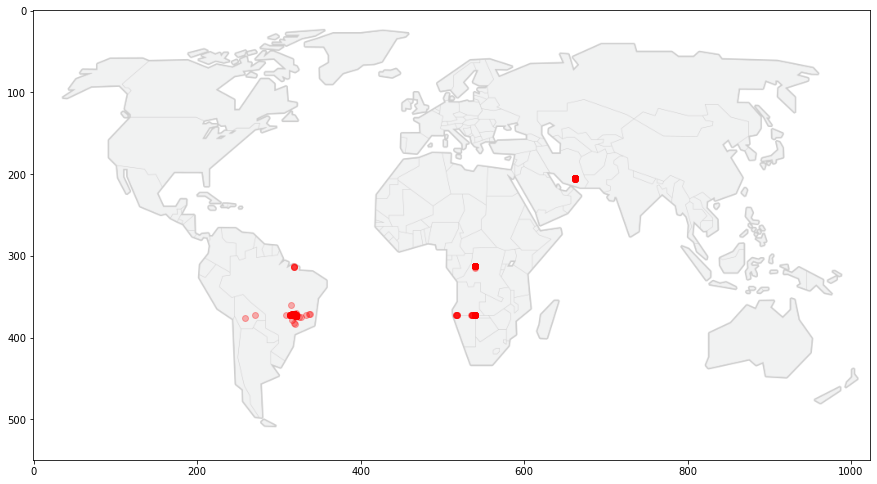

In [21]:
plt.figure(figsize=[15,10])
a=plt.imread('https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/wm.png')
plt.imshow(a, alpha=0.2)
plt.scatter( (df.pickup_longitude+180)*3,(df.pickup_latitude+215)*1.45555555,alpha=0.3, color='red')
plt.show()

Поработаем с колонкой pickup_datetime, обозначающее время начала поездки. Разобьем точно время на год, месяц, неделю и час. Знание точного месяца и часа начала поездки скорее всего ничего не даст для анализа. Будем выделять не точный месяц, а триплет месяцев. В сутках будемя выделять не точный час, а также разобьем сутки на 4 сектора.

Также добавил новую колонку Distance, обознучающее дистанцию поездки. Вычислим ее для каждой строки с помощью координат начала и конца поездки.

In [22]:
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)
df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour
df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                       8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})
df['Hourly_Segments'] = df.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H1',5:'H1',6:'H2',7:'H2',8:'H2',
                                     9:'H2',10:'H2',11:'H2',12:'H3',13:'H3',14:'H3',15:'H3',16:'H3',
                                     17:'H3',18:'H4',19:'H4',20:'H4',21:'H4',22:'H4',23:'H4'})
df['weekday'] = df.weekday.map({0:'Mon',1:'Tue',2:'Wen',3:'Thi',4:'Fri',5:'Sat',6:'Sun'})


df['Distance']=[round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),(df.dropoff_latitude[i], df.dropoff_longitude[i])).km,2) for i in df.index]

df.drop(['pickup_datetime', 'month', 'hour',], axis=1, inplace=True)

original_df = df.copy(deep=True)

df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,Thi,Q2,H4,1.68
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,Fri,Q3,H4,2.45
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,Mon,Q3,H4,5.04
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,Fri,Q2,H2,1.66
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,Thi,Q3,H3,4.48


In [23]:
nu = df.drop([target], axis=1).nunique().sort_values()
nf = []
cf = []

for i in range(df.drop([target], axis=1).shape[1]):
    if nu.values[i]<=24:
        cf.append(nu.index[i])
    else: 
        nf.append(nu.index[i])

print('\nТеперь датасет имеет 5 количестенных и 5 категориальных признаков.')


Теперь датасет имеет 5 количестенных и 5 категориальных признаков.


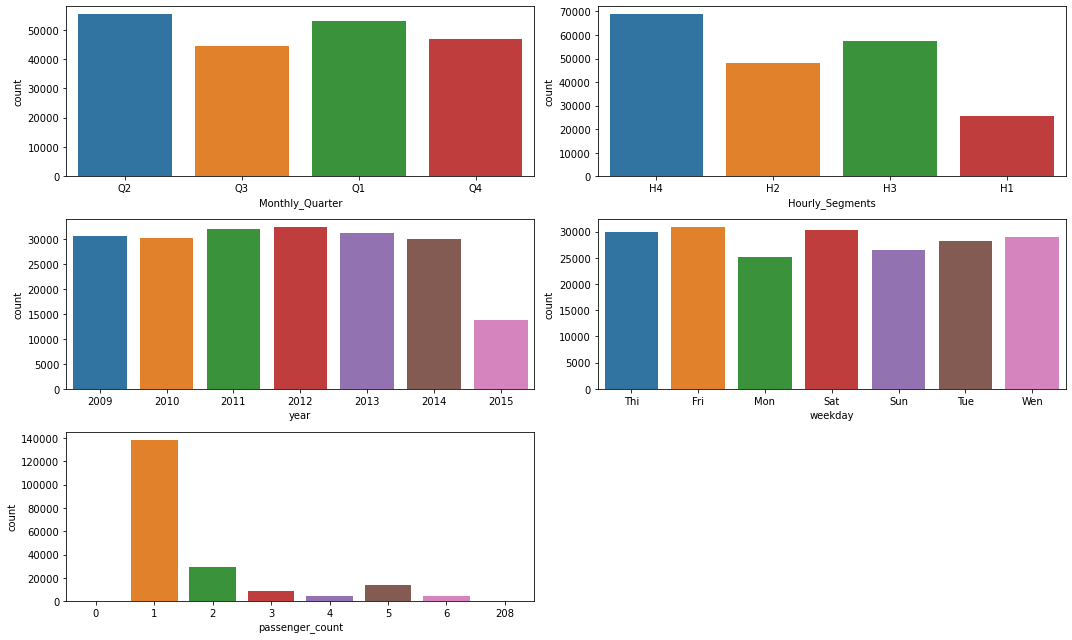

In [25]:
n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=12:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-3)
        sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

Колонка passenger_count имеет значение экстремальное значение 208. Удалим сразу строки с таким значения количества пассажиров.

In [26]:
df_drop_passenger_208_0 = df[(df['passenger_count'] == 208) | (df['passenger_count'] == 0)]
df = df[(df['passenger_count'] != 208) | (df['passenger_count'] != 0)]


                                 Numeric Features Distribution                                  


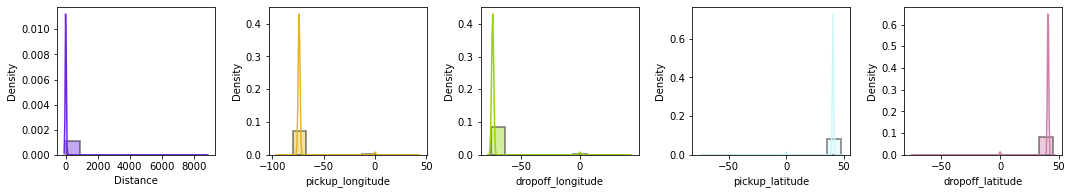

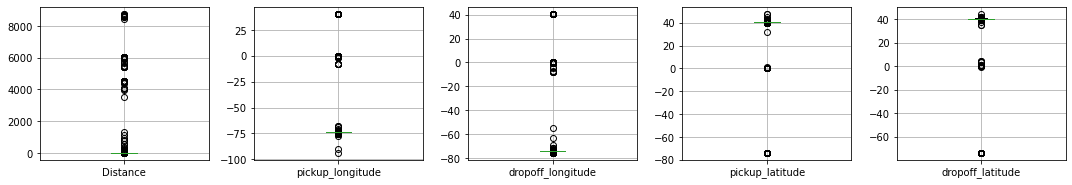

In [27]:
print('\033[1mNumeric Features Distribution'.center(100))

n=5

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

Удаление невозможных значений

In [28]:
df['pickup_latitude'].value_counts().nlargest(5)

0.000000     3782
41.366138      72
40.774000      20
40.755900      20
40.774100      20
Name: pickup_latitude, dtype: int64

In [29]:
df['pickup_longitude'].value_counts().nlargest(5)

 0.000000     3786
-73.137393      72
-73.981397      20
-73.982017      20
-73.982600      20
Name: pickup_longitude, dtype: int64

In [30]:
df['dropoff_longitude'].value_counts().nlargest(5)

 0.000000     3764
-73.137393      65
-73.980400      21
-73.991025      21
-73.978952      20
Name: dropoff_longitude, dtype: int64

In [31]:
df['dropoff_latitude'].value_counts().nlargest(5)

0.000000     3758
41.366138      65
40.750207      21
40.756400      17
40.750322      16
Name: dropoff_latitude, dtype: int64

Наблюдается достаточно большое количество значений с координатами в точке 0.0

In [32]:
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,Thi,Q2,H4,1.68
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,Fri,Q3,H4,2.45
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,Mon,Q3,H4,5.04
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,Fri,Q2,H2,1.66
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,Thi,Q3,H3,4.48
...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,Sun,Q4,H2,0.11
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,Fri,Q1,H1,1.88
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,Mon,Q2,H1,12.87
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,Wen,Q2,H3,3.54


Удалим строки с неположительными значениями в колонках Distance и fare_amount. Также удалим строки с координатами 0.0 по широте и долготе. Местоположение с координатами 0, 0 находится в океане. Предположительно данное значение проставлялось автоматически, в случае неимения информации по местоположению начала и конца поездки.

In [33]:
outlier_data = df[(df['fare_amount']<=0) | (df['Distance']<=0) | 
                 ((df['pickup_latitude']==0.000000) & (df['pickup_longitude']==0.000000)) |
                 ((df['dropoff_latitude']==0.000000) & (df['dropoff_longitude']==0.000000))]
outlier_data

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
5,4.9,-73.969019,40.755910,-73.969019,40.755910,1,2011,Sat,Q1,H1,0.0
7,2.5,0.000000,0.000000,0.000000,0.000000,1,2012,Tue,Q4,H3,0.0
11,8.5,0.000000,0.000000,0.000000,0.000000,1,2011,Mon,Q2,H4,0.0
48,56.8,-73.993498,40.764686,-73.993498,40.764686,1,2013,Thi,Q1,H4,0.0
65,6.0,0.000000,0.000000,0.000000,0.000000,1,2014,Mon,Q2,H4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
199880,6.5,0.000000,0.000000,0.000000,0.000000,1,2014,Sat,Q1,H2,0.0
199883,12.5,0.000000,0.000000,0.000000,0.000000,2,2012,Mon,Q3,H3,0.0
199917,4.5,-73.793768,40.656939,-73.793768,40.656939,1,2013,Mon,Q2,H4,0.0
199932,24.9,-73.974618,40.756295,-73.974618,40.756295,5,2011,Tue,Q1,H3,0.0


In [34]:
df=df[(df['fare_amount']>0) & (df['Distance']>0) & 
         ((df['pickup_latitude']!=0.000000) & (df['pickup_longitude']!=0.000000)) &
         ((df['dropoff_latitude']!=0.000000) & (df['dropoff_longitude']!=0.000000))]
print(f'\nПосле удаления невозможных значений датасет имеет ---> {df.shape[0]}')


После удаления невозможных значений датасет имеет ---> 193592


In [35]:
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,Thi,Q2,H4,1.68
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,Fri,Q3,H4,2.45
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,Mon,Q3,H4,5.04
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,Fri,Q2,H2,1.66
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,Thi,Q3,H3,4.48
...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,Sun,Q4,H2,0.11
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,Fri,Q1,H1,1.88
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,Mon,Q2,H1,12.87
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,Wen,Q2,H3,3.54


# Data Preprocessing

In [37]:
#Удаление дупликатов при их наличии

df.drop_duplicates(inplace=True)
df.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)

print(f'\nКоличество убранных значений ---> {original_df.shape[0]-df.shape[0]}')


Количество убранных значений ---> 6395


In [38]:
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,Thi,Q2,H4,1.68
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,Fri,Q3,H4,2.45
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,Mon,Q3,H4,5.04
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,Fri,Q2,H2,1.66
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,Thi,Q3,H3,4.48
...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,Sun,Q4,H2,0.11
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,Fri,Q1,H1,1.88
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,Mon,Q2,H1,12.87
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,Wen,Q2,H3,3.54


In [39]:
df1 = pd.get_dummies(df['Monthly_Quarter'], drop_first = True)
df = pd.concat([df, df1], axis=1).reindex(df.index)
df.drop('Monthly_Quarter', axis=1, inplace=True)

In [40]:
df1 = pd.get_dummies(df['weekday'], drop_first = True)
df = pd.concat([df, df1], axis=1).reindex(df.index)
df.drop('weekday', axis=1, inplace=True)

In [41]:
df1 = pd.get_dummies(df['Hourly_Segments'], drop_first = True)
df = pd.concat([df, df1], axis=1).reindex(df.index)
df.drop('Hourly_Segments', axis=1, inplace=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Distance,Q2,Q3,Q4,Mon,Sat,Sun,Thi,Tue,Wen,H2,H3,H4
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,1.68,1,0,0,0,0,0,1,0,0,0,0,1
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,2.45,0,1,0,0,0,0,0,0,0,0,0,1
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,5.04,0,1,0,1,0,0,0,0,0,0,0,1
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,1.66,1,0,0,0,0,0,0,0,0,1,0,0
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,4.48,0,1,0,0,0,0,1,0,0,0,1,0


In [43]:
df1 = df.copy()
df2 = df.copy()
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print(f'\nПеред удалением выбросов, датасет имел {df.shape[0]} строк.')
print(f'\nПосле удаления выбросов, датасет имеет {df1.shape[0]} строк.')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Distance,Q2,Q3,Q4,Mon,Sat,Sun,Thi,Tue,Wen,H2,H3,H4
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,1.68,1,0,0,0,0,0,1,0,0,0,0,1
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,2.45,0,1,0,0,0,0,0,0,0,0,0,1
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,5.04,0,1,0,1,0,0,0,0,0,0,0,1
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,1.66,1,0,0,0,0,0,0,0,0,1,0,0
4,9.7,-73.975187,40.745767,-74.002720,40.743537,1,2012,2.34,0,0,0,0,0,0,0,0,0,1,0,0



Перед удалением выбросов, датасет имел 193592 строк.

После удаления выбросов, датасет имеет 165628 строк.


In [44]:
df = df1
df.reset_index(drop=True, inplace=True)
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Distance,Q2,Q3,Q4,Mon,Sat,Sun,Thi,Tue,Wen,H2,H3,H4
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,1.68,1,0,0,0,0,0,1,0,0,0,0,1
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,2.45,0,1,0,0,0,0,0,0,0,0,0,1
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,5.04,0,1,0,1,0,0,0,0,0,0,0,1
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,1.66,1,0,0,0,0,0,0,0,0,1,0,0
4,9.7,-73.975187,40.745767,-74.002720,40.743537,1,2012,2.34,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165623,12.0,-73.983070,40.760770,-73.972972,40.754177,1,2014,1.12,0,0,0,0,0,0,0,0,0,0,1,0
165624,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,0.11,0,0,1,0,0,1,0,0,0,1,0,0
165625,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,1.88,0,0,0,0,0,0,0,0,0,0,0,0
165626,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,3.54,1,0,0,0,0,0,0,0,1,0,1,0


In [45]:
df.columns.values

array(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'Distance', 'Q2', 'Q3', 'Q4', 'Mon', 'Sat', 'Sun', 'Thi', 'Tue',
       'Wen', 'H2', 'H3', 'H4'], dtype=object)

# Normalization

In [46]:
m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X, Val_X, Train_Y, Val_Y = train_test_split(Train_X, Train_Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)
Test_X.reset_index(drop=True,inplace=True)
Train_Y.reset_index(drop=True,inplace=True)
Test_Y.reset_index(drop=True,inplace=True)
Val_X.reset_index(drop=True,inplace=True)
Val_Y.reset_index(drop=True,inplace=True)
print('Original set ',X.shape,Y.shape,'\nTraining set ',Train_X.shape,Train_Y.shape,'\nTesting set ', Test_X.shape,'', Test_Y.shape,'\nValid set ', Val_X.shape,'', Val_Y.shape)

Original set  (165628, 19) (165628,) 
Training set  (106001, 19) (106001,) 
Testing set  (33126, 19)  (33126,) 
Valid set  (26501, 19)  (26501,)


In [47]:
#Feature Scaling (Standardization)

std = StandardScaler()

features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'Distance']
x = Train_X.loc[:, features].values

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(x)
Train_X_std = pd.DataFrame(Train_X_std, columns=features)

Train_X_1 = Train_X.loc[:,['passenger_count', 'year', 'Q2', 'Q3','Q4', 'H2', 'H3', 'H4'
                          , 'Mon', 'Tue', 'Wen', 'Thi', 'Sat', 'Sun']]
Train_X_std = pd.concat([Train_X_std, Train_X_1], axis=1)
display(Train_X_std.describe())

x = Test_X.loc[:, features].values
print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(x)
Test_X_std = pd.DataFrame(Test_X_std, columns=features)
Test_X_1 = Test_X.loc[:,['passenger_count', 'year', 'Q2', 'Q3','Q4', 'H2', 'H3', 'H4'
                          , 'Mon', 'Tue', 'Wen', 'Thi', 'Sat', 'Sun']]
Test_X_std = pd.concat([Test_X_std, Test_X_1], axis=1)
display(Test_X_std.describe())

x = Val_X.loc[:, features].values
print('\n','\033[1mStandardardization on Valid set'.center(100))
Val_X_std = std.transform(x)
Val_X_std = pd.DataFrame(Val_X_std, columns=features)
Val_X_1 = Val_X.loc[:,['passenger_count', 'year', 'Q2', 'Q3','Q4', 'H2', 'H3', 'H4'
                      , 'Mon', 'Tue', 'Wen', 'Thi', 'Sat', 'Sun']]
Val_X_std = pd.concat([Val_X_std, Val_X_1], axis=1)
display(Val_X_std.describe())



                               Standardardization on Training set                               


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,passenger_count,year,Q2,Q3,Q4,H2,H3,H4,Mon,Tue,Wen,Thi,Sat,Sun
count,1.060010e+05,1.060010e+05,1.060010e+05,1.060010e+05,1.060010e+05,106001.000000,106001.000000,106001.000000,106001.000000,106001.000000,106001.000000,106001.000000,106001.000000,106001.000000,106001.000000,106001.000000,106001.000000,106001.000000,106001.000000
mean,5.964396e-13,5.320581e-14,3.227003e-13,4.061994e-14,-2.647752e-17,1.685692,2011.729870,0.273601,0.220356,0.235969,0.246149,0.295497,0.346374,0.124772,0.142951,0.147093,0.150999,0.151527,0.126838
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.452925,1.862285,0.445809,0.414489,0.424605,0.430768,0.456268,0.475816,0.330462,0.350025,0.354200,0.358049,0.358563,0.332793
min,-2.744599e+00,-2.832864e+00,-2.710399e+00,-2.732405e+00,-1.516945e+00,0.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.782637e-01,-6.898547e-01,-6.725184e-01,-6.702723e-01,-7.460227e-01,1.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-5.664157e-02,3.739374e-02,-5.858948e-02,5.087669e-02,-2.666257e-01,1.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.514474e-01,6.578805e-01,6.309592e-01,6.472166e-01,4.848616e-01,2.000000,2013.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.840835e+00,2.765446e+00,2.771914e+00,2.681432e+00,3.620377e+00,208.000000,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



                                Standardardization on Testing set                                


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,passenger_count,year,Q2,Q3,Q4,H2,H3,H4,Mon,Tue,Wen,Thi,Sat,Sun
count,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000
mean,-0.008859,-0.003575,-0.009429,-0.003104,0.001180,1.679617,2011.726680,0.276490,0.223510,0.235404,0.248234,0.293395,0.347401,0.127151,0.142305,0.146350,0.153384,0.150909,0.126155
std,0.998354,1.007213,0.996680,1.001576,1.000620,1.304122,1.858962,0.447269,0.416604,0.424258,0.431995,0.455325,0.476152,0.333147,0.349368,0.353462,0.360363,0.357965,0.332029
min,-2.731889,-2.831862,-2.650071,-2.731681,-1.516945,0.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.689134,-0.695961,-0.672910,-0.669492,-0.746023,1.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.065387,0.036273,-0.060245,0.056626,-0.266626,1.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.635639,0.662329,0.614568,0.637733,0.504297,2.000000,2013.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.834418,2.764492,2.772215,2.680467,3.620377,6.000000,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



                                 Standardardization on Valid set                                 


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,passenger_count,year,Q2,Q3,Q4,H2,H3,H4,Mon,Tue,Wen,Thi,Sat,Sun
count,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000,26501.000000
mean,0.013645,0.013091,-0.002210,0.004435,-0.004962,1.684465,2011.737746,0.277612,0.220595,0.234293,0.250368,0.293423,0.343610,0.125505,0.145013,0.144976,0.150108,0.152673,0.127769
std,1.009306,1.006487,0.999741,1.003855,0.997335,1.307994,1.857482,0.447829,0.414656,0.423564,0.433233,0.455339,0.474922,0.331297,0.352121,0.352083,0.357184,0.359679,0.333838
min,-2.763789,-2.831767,-2.583121,-2.729508,-1.516945,0.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.676770,-0.676688,-0.668906,-0.665564,-0.752501,1.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.043492,0.060673,-0.055519,0.051194,-0.273104,1.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.670149,0.683641,0.616389,0.651517,0.491340,2.000000,2013.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.831335,2.756859,2.770709,2.678566,3.620377,6.000000,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Future selection

                                       Correlation Matrix                                       


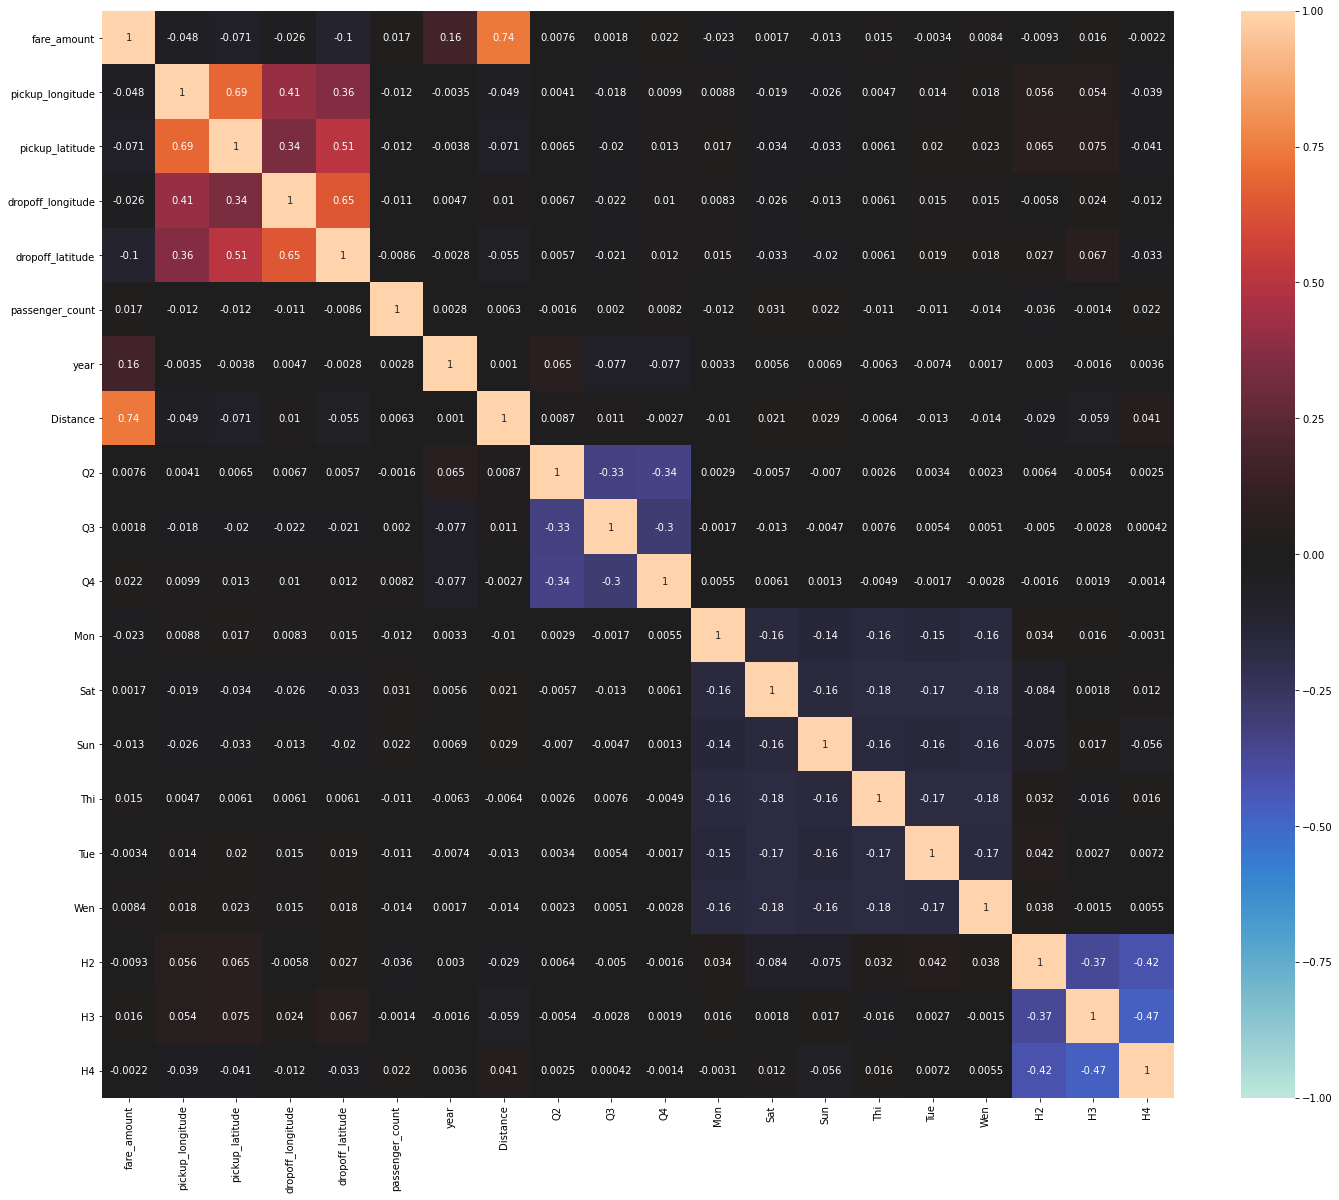

In [48]:
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[24,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) 
plt.show()

PCA

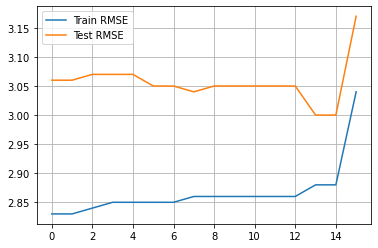

In [56]:
from sklearn.decomposition import PCA
Train_RMSE=[]
Test_RMSE=[]

m=df.shape[1]-4
for i in range(m):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Train_RMSE.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Test_RMSE.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))

plt.plot(Train_RMSE, label='Train RMSE')
plt.plot(Test_RMSE, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

RFE

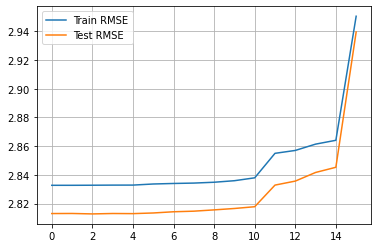

In [58]:
Train_RMSE=[]
Test_RMSE=[]
 
m=df.shape[1]-4
for i in range(m):

    rfe = RFE(LinearRegression(),n_features_to_select=Train_X_std.shape[1]-i)            
    rfe = rfe.fit(Train_X_std, Train_Y)
    
    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Train_RMSE.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Test_RMSE.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.plot(Train_RMSE, label='Train RMSE')
plt.plot(Test_RMSE, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

RFE показала себя лучше, чем PCA

In [59]:
rfe = RFE(LinearRegression(),n_features_to_select=df.shape[1]-10)           
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

Train_X_std = Train_X_std.loc[:,rfe.support_]
Val_X_std = Val_X_std.loc[:,rfe.support_]
Test_X_std = Test_X_std.loc[:,rfe.support_]

2.835965404212021
2.816631413168682


# Training

In [60]:
def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [73]:
For_Comparing = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-MSE','Test-MSE','Train-RMSE','Test-RMSE',
                                                                            'Train-SMAPE', 'Test-SMAPE'])

def Evaluate(n, pred1,pred2):

    print('\nTraining Set Metrics')
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))
    print('Symmetric Mean Absolute Percentage Error (SMAPE) on Training set --->',round(np.sqrt(smape(Train_Y, pred1)),20))

    print('\nTesting Set Metrics')
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Mean Squared Error (MSE) on Test set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Test set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('Symmetric Mean Absolute Percentage Error (SMAPE) on Test set --->',round(np.sqrt(smape(Test_Y, pred2)),20))
    
    For_Comparing.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    For_Comparing.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    For_Comparing.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    For_Comparing.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    For_Comparing.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    For_Comparing.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)
    For_Comparing.loc[n,'Train-SMAPE']= round(np.sqrt(smape(Train_Y, pred1)),20)
    For_Comparing.loc[n,'Test-SMAPE'] = round(np.sqrt(smape(Test_Y, pred2)),20)

    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Regression line')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred') 
    
    plt.subplot(1,2,2)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 
    
    plt.show()

Linear Regression

                        Evaluating Multiple Linear Regression Model
                        

Training Set Metrics

R2-Score on Training set ---> 0.5831513108503328
Mean Squared Error (MSE) on Training set       ---> 8.04269977388745
Root Mean Squared Error (RMSE) on Training set ---> 2.835965404212021
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.42858647372003345

Testing Set Metrics

R2-Score on Testing set ---> 0.5888451666916386
Mean Squared Error (MSE) on Test set       ---> 7.933412517648607
Root Mean Squared Error (RMSE) on Test set ---> 2.816631413168682
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.42749972008609216


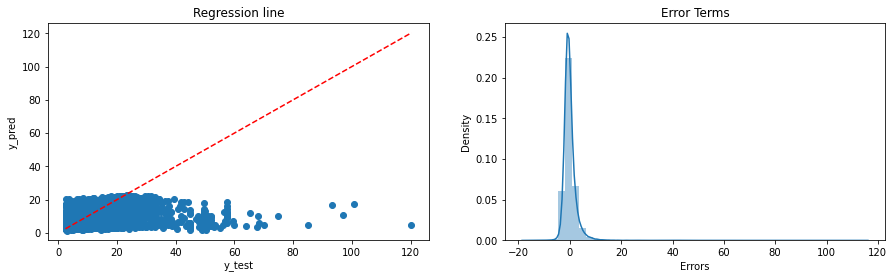

In [76]:
LR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = LR.predict(Train_X_std)
pred2 = LR.predict(Test_X_std)

print('\033[1mResults of Linear Regression Model\033[0m\n'.center(100))


Evaluate(0, pred1, pred2)

Ridge Regression 

                             Results of Ridge Regression Model
                             

Training Set Metrics

R2-Score on Training set ---> 0.5831513105207184
Mean Squared Error (MSE) on Training set       ---> 8.042699780247045
Root Mean Squared Error (RMSE) on Training set ---> 2.8359654053332606
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.4285866134430936

Testing Set Metrics

R2-Score on Testing set ---> 0.5888451229306957
Mean Squared Error (MSE) on Test set       ---> 7.933413362035161
Root Mean Squared Error (RMSE) on Test set ---> 2.8166315630616583
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.42749995525587764


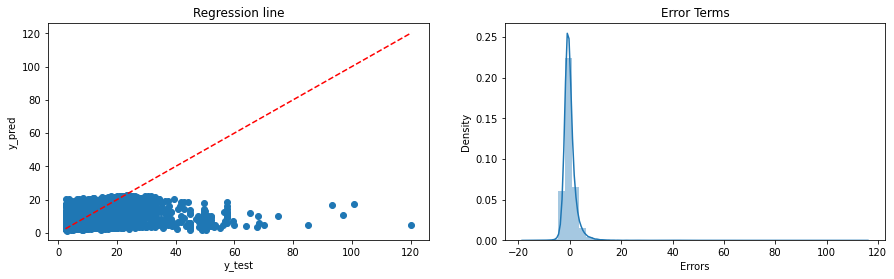

In [77]:
RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('\033[1mResults of Ridge Regression Model\033[0m\n'.center(100))


Evaluate(1, pred1, pred2)

Lasso Regression Model

                             Results of Lasso Regression Model
                             

Training Set Metrics

R2-Score on Training set ---> 0.5022846747738554
Mean Squared Error (MSE) on Training set       ---> 9.602944756339117
Root Mean Squared Error (RMSE) on Training set ---> 3.0988618485403827
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.4750931061446632

Testing Set Metrics

R2-Score on Testing set ---> 0.5055749254752205
Mean Squared Error (MSE) on Test set       ---> 9.54014827872014
Root Mean Squared Error (RMSE) on Test set ---> 3.088713045706924
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.4754962422119364


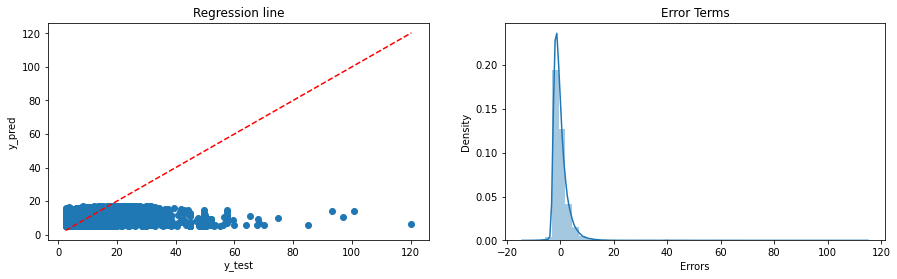

In [78]:
LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('\033[1mResults of Lasso Regression Model\033[0m\n'.center(100))

Evaluate(2, pred1, pred2)

Elastic-Net Regression

                          Results of ElasticNet Regression Model
                           

Training Set Metrics

R2-Score on Training set ---> 0.460264858656807
Mean Squared Error (MSE) on Training set       ---> 10.413677222051724
Root Mean Squared Error (RMSE) on Training set ---> 3.227022965838905
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.49168607969147804

Testing Set Metrics

R2-Score on Testing set ---> 0.463862685497751
Mean Squared Error (MSE) on Test set       ---> 10.345004211249657
Root Mean Squared Error (RMSE) on Test set ---> 3.2163650618749196
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.49208309629811214


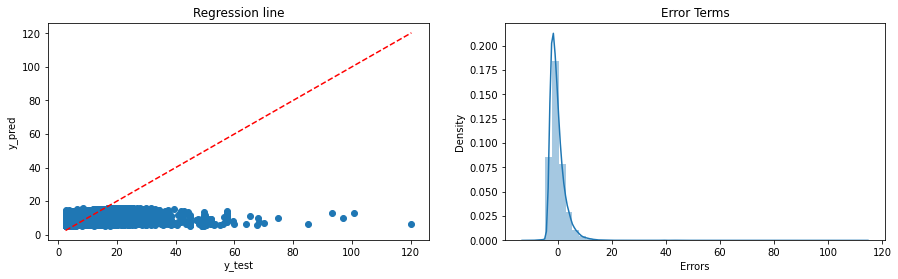

In [79]:
ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('\033[1mResults of ElasticNet Regression Model\033[0m\n'.center(100))

Evaluate(3, pred1, pred2)

Polynomial Regression

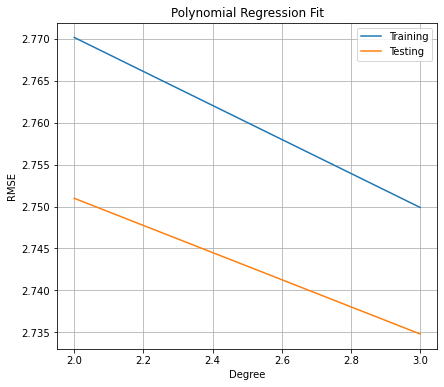

In [82]:
Train_RMSE=[] 
Test_RMSE=[]
n_degree=4

for i in range(2,n_degree):
    poly = PolynomialFeatures(degree=i)
    poly_train = poly.fit_transform(Train_X_std)
    poly_test = poly.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(poly_train, Train_Y)
    
    pred1 = LR.predict(poly_train)
    Train_RMSE.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(poly_test)
    Test_RMSE.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Train_RMSE, label='Training')
plt.plot(range(2,n_degree),Test_RMSE, label='Testing')

plt.title('Polynomial Regression Fit')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()

plt.show()


                          Results of Polynomial Regression Model
                           

Training Set Metrics

R2-Score on Training set ---> 0.6080708164829235
Mean Squared Error (MSE) on Training set       ---> 7.561901566927839
Root Mean Squared Error (RMSE) on Training set ---> 2.749891191834295
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.418389596469229

Testing Set Metrics

R2-Score on Testing set ---> 0.6123847098076025
Mean Squared Error (MSE) on Test set       ---> 7.479206727306218
Root Mean Squared Error (RMSE) on Test set ---> 2.734813837778765
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.41829592147836414


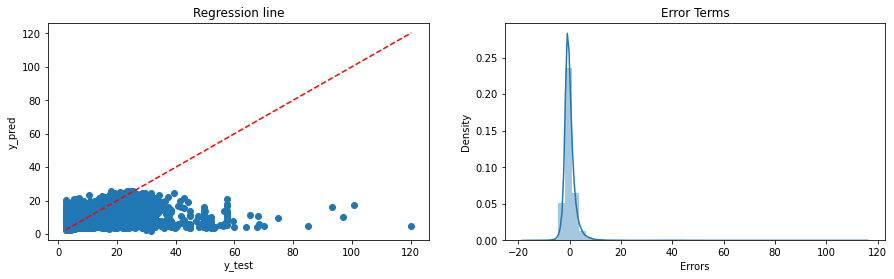

In [83]:
poly = PolynomialFeatures(degree=3)
poly_train = poly.fit_transform(Train_X_std)
poly_test = poly.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(poly_train, Train_Y)

pred1 = PR.predict(poly_train)
pred2 = PR.predict(poly_test)

print('\033[1mResults of Polynomial Regression Model\033[0m\n'.center(100))

Evaluate(4, pred1, pred2)

NN

In [84]:
def build_model(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu']) 
    
    model.add(Dense(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=8,   
                                   max_value=512,   
                                   step=16),
                    input_dim=(Train_X_std.shape[1]),
                    activation=activation_choice))
    
#     for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
#       model.add(Dense(units=hyperparams.Int('units_hidden',     
#                                    min_value=8,   
#                                    max_value=512,   
#                                    step=16),
#                       activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

In [85]:
from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model,
                      objective="val_mean_absolute_error",
                      max_trials=20,
                      project_name="Uber",
                      overwrite=True
                    )

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner1.search(Train_X_std, Train_Y, batch_size=128, epochs=20, validation_data=(Val_X_std, Val_Y), callbacks=[callback])

Trial 20 Complete [00h 00m 07s]
val_mean_absolute_error: nan

Best val_mean_absolute_error So Far: 1.6987059116363525
Total elapsed time: 00h 06m 02s
INFO:tensorflow:Oracle triggered exit


In [86]:
tuner1.search_space_summary()

Search space summary
Default search space size: 3
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh', 'elu', 'selu'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': None}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'rmsprop', 'adam'], 'ordered': False}


In [87]:
best_params = tuner1.get_best_hyperparameters()

best_params[0].values

{'activation': 'elu', 'units_input': 504, 'optimizer': 'rmsprop'}

In [88]:
best_model = tuner1.get_best_models()[0]



best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 504)               5544      
                                                                 
 dense_1 (Dense)             (None, 1)                 505       
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


1036/1036 [==============================] - 2s 2ms/step
                                    Results of NN Model
                                    

Training Set Metrics

R2-Score on Training set ---> 0.5523060944850995
Mean Squared Error (MSE) on Training set       ---> 8.6378289445998
Root Mean Squared Error (RMSE) on Training set ---> 2.9390183641140797
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.4311786786852753

Testing Set Metrics

R2-Score on Testing set ---> 0.5559888630858301
Mean Squared Error (MSE) on Test set       ---> 8.56738928064215
Root Mean Squared Error (RMSE) on Test set ---> 2.9270102973242422
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.430755255703421


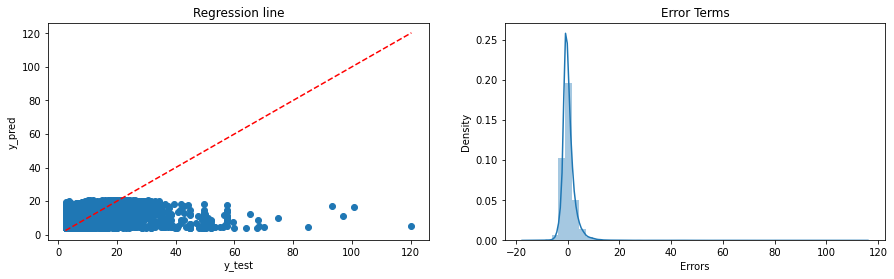

In [91]:
pred1 = best_model.predict(Train_X_std)
pred1 = pred1.reshape(pred1.shape[0])
pred2 = best_model.predict(Test_X_std)
pred2 = pred2.reshape(pred2.shape[0])

print('\033[1mResults of NN Model\033[0m\n'.center(100))


Evaluate(5, pred1, pred2)

RNN

In [92]:
train_X = Train_X_std.values
test_X = Test_X_std.values
val_X = Val_X_std.values
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [93]:
def build_model_RNN(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu']) 
    
    model.add(LSTM(units=hyperparams.Int('units_input',    
                                   min_value=8,   
                                   max_value=512,   
                                   step=16),
                    input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice))
    
#     for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
#       model.add(LSTM(units=hyperparams.Int('units_hidden',     
#                                    min_value=8,   
#                                    max_value=512,   
#                                    step=16),
#                       activation=activation_choice, return_sequences=True))
    
#     model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
#                                    min_value=8,   
#                                    max_value=512,   
#                                    step=16),
#                     activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

In [94]:
from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_RNN,
                      objective="val_mean_absolute_error",
                      max_trials=20,
                      project_name="Uber2",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner1.search(train_X, Train_Y, batch_size=128, epochs=20, validation_data=(val_X, Val_Y), callbacks=[callback])

Trial 20 Complete [00h 00m 25s]
val_mean_absolute_error: 3.2135636806488037

Best val_mean_absolute_error So Far: 1.679940104484558
Total elapsed time: 00h 25m 06s
INFO:tensorflow:Oracle triggered exit


In [95]:
tuner1.search_space_summary()

Search space summary
Default search space size: 3
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh', 'elu', 'selu'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': None}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'rmsprop', 'adam'], 'ordered': False}


In [96]:
best_params = tuner1.get_best_hyperparameters()

best_params[0].values

{'activation': 'elu', 'units_input': 376, 'optimizer': 'adam'}

In [97]:
best_model = tuner1.get_best_models()[0]



best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 376)               582048    
                                                                 
 dense (Dense)               (None, 1)                 377       
                                                                 
Total params: 582,425
Trainable params: 582,425
Non-trainable params: 0
_________________________________________________________________


1036/1036 [==============================] - 4s 4ms/step
                                   Results of RNN Model
                                    

Training Set Metrics

R2-Score on Training set ---> 0.543056689156469
Mean Squared Error (MSE) on Training set       ---> 8.816287440647656
Root Mean Squared Error (RMSE) on Training set ---> 2.969223373316271
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.42774487249080556

Testing Set Metrics

R2-Score on Testing set ---> 0.5467908107924886
Mean Squared Error (MSE) on Test set       ---> 8.744869726669775
Root Mean Squared Error (RMSE) on Test set ---> 2.957172589936166
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.42690927463140377


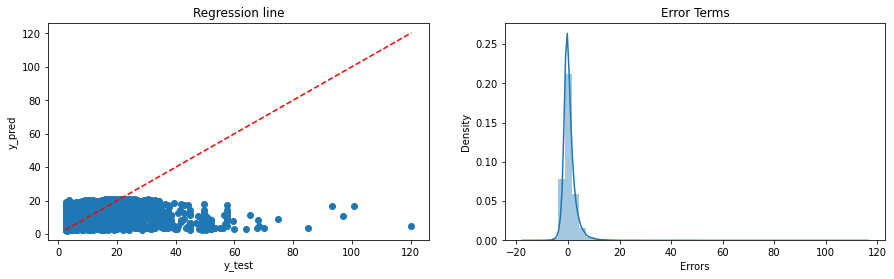

In [98]:
pred1 = best_model.predict(train_X)
pred1 = pred1.reshape(pred1.shape[0])
pred2 = best_model.predict(test_X)
pred2 = pred2.reshape(pred2.shape[0])

print('\033[1mResults of RNN Model\033[0m\n'.center(100))


Evaluate(6, pred1, pred2)

# Comparing

In [100]:
Table_of_Comapring = For_Comparing.copy()
Table_of_Comapring.index = ['Linear Regression','Ridge Linear Regression','Lasso Linear Regression','Elastic-Net Regression','Polynomial Regression', 'NN', 'RNN']
Table_of_Comapring

,Train-R2,Test-R2,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE,Train-SMAPE,Test-SMAPE
Linear Regression,0.583151,0.588845,8.042700,7.933413,2.835965,2.816631,0.428586,0.427500
Ridge Linear Regression,0.583151,0.588845,8.042700,7.933413,2.835965,2.816632,0.428587,0.427500
Lasso Linear Regression,0.502285,0.505575,9.602945,9.540148,3.098862,3.088713,0.475093,0.475496
Elastic-Net Regression,0.460265,0.463863,10.413677,10.345004,3.227023,3.216365,0.491686,0.492083
Polynomial Regression,0.608071,0.612385,7.561902,7.479207,2.749891,2.734814,0.418390,0.418296
NN,0.552306,0.555989,8.637829,8.567389,2.939018,2.927010,0.431179,0.430755
RNN,0.543057,0.546791,8.816287,8.744870,2.969223,2.957173,0.427745,0.426909


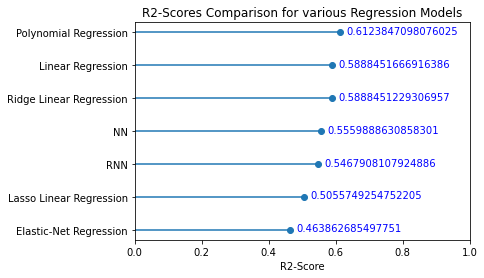

In [101]:
R2 = Table_of_Comapring['Test-R2'].sort_values(ascending=True)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v), color='blue')
plt.xlim([0,1])
plt.show()

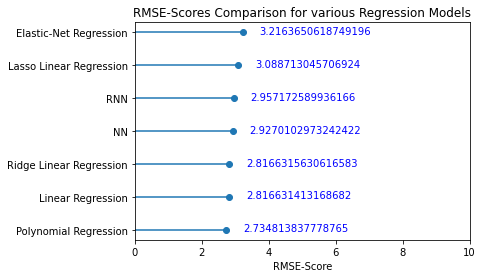

In [102]:
RMSE = Table_of_Comapring['Test-RMSE'].sort_values(ascending=True)
plt.hlines(y=RMSE.index, xmin=0, xmax=RMSE.values)
plt.plot(RMSE.values, RMSE.index,'o')
plt.title('RMSE-Scores Comparison for various Regression Models')
plt.xlabel('RMSE-Score')
for i, v in enumerate(RMSE):
    plt.text(v+0.5, i-0.05, str(v), color='blue')
plt.xlim([0,10])
plt.show()

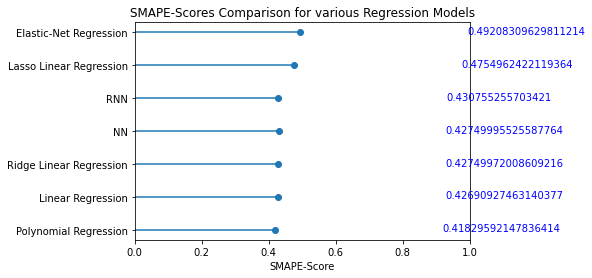

In [103]:
SMAPE = Table_of_Comapring['Test-SMAPE'].sort_values(ascending=True)
plt.hlines(y=RMSE.index, xmin=0, xmax=SMAPE.values)
plt.plot(SMAPE.values, SMAPE.index,'o')
plt.title('SMAPE-Scores Comparison for various Regression Models')
plt.xlabel('SMAPE-Score')
for i, v in enumerate(SMAPE):
    plt.text(v+0.5, i-0.05, str(v), color='blue')
plt.xlim([0,1])
plt.show()

# Without coordinates

In [151]:
df2 = df2[df2['Distance'] < 50]
df2

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Distance,Q2,Q3,Q4,Mon,Sat,Sun,Thi,Tue,Wen,H2,H3,H4
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,1.68,1,0,0,0,0,0,1,0,0,0,0,1
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,2.45,0,1,0,0,0,0,0,0,0,0,0,1
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,5.04,0,1,0,1,0,0,0,0,0,0,0,1
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,1.66,1,0,0,0,0,0,0,0,0,1,0,0
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,4.48,0,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193482,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,0.11,0,0,1,0,0,1,0,0,0,1,0,0
193483,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,1.88,0,0,0,0,0,0,0,0,0,0,0,0
193484,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,12.87,1,0,0,1,0,0,0,0,0,0,0,0
193485,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,3.54,1,0,0,0,0,0,0,0,1,0,1,0


In [152]:
df2.reset_index(drop=True, inplace=True)
df2

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Distance,Q2,Q3,Q4,Mon,Sat,Sun,Thi,Tue,Wen,H2,H3,H4
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,1.68,1,0,0,0,0,0,1,0,0,0,0,1
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,2.45,0,1,0,0,0,0,0,0,0,0,0,1
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,5.04,0,1,0,1,0,0,0,0,0,0,0,1
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,1.66,1,0,0,0,0,0,0,0,0,1,0,0
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,4.48,0,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193482,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,0.11,0,0,1,0,0,1,0,0,0,1,0,0
193483,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,1.88,0,0,0,0,0,0,0,0,0,0,0,0
193484,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,12.87,1,0,0,1,0,0,0,0,0,0,0,0
193485,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,3.54,1,0,0,0,0,0,0,0,1,0,1,0


In [153]:
X = df2.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','fare_amount'],axis=1)
Y = df2['fare_amount']

# Feature Selection with VIF

In [154]:
vif_df= pd.DataFrame()
vif_df['Feature'] = X.columns
vif_df['Vif']= [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

vif_df

,Feature,Vif
0,passenger_count,2.479430
1,year,19.169742
2,Distance,1.884233
3,Q2,2.040955
4,Q3,1.837686
5,Q4,1.886001
6,Mon,1.819835
7,Sat,1.996354
8,Sun,1.886599
9,Thi,1.973865


In [155]:
X.drop(['year','H2','H3','H4'],axis=1,inplace=True)
vif_df= pd.DataFrame()
vif_df['Feature'] = X.columns
vif_df['Vif']= [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif_df

,Feature,Vif
0,passenger_count,2.171678
1,Distance,1.747788
2,Q2,1.709028
3,Q3,1.572486
4,Q4,1.606985
5,Mon,1.358913
6,Sat,1.435781
7,Sun,1.392234
8,Thi,1.422815
9,Tue,1.393201


In [156]:
X

,passenger_count,Distance,Q2,Q3,Q4,Mon,Sat,Sun,Thi,Tue,Wen
0,1,1.68,1,0,0,0,0,0,1,0,0
1,1,2.45,0,1,0,0,0,0,0,0,0
2,1,5.04,0,1,0,1,0,0,0,0,0
3,3,1.66,1,0,0,0,0,0,0,0,0
4,5,4.48,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
193482,1,0.11,0,0,1,0,0,1,0,0,0
193483,1,1.88,0,0,0,0,0,0,0,0,0
193484,2,12.87,1,0,0,1,0,0,0,0,0
193485,1,3.54,1,0,0,0,0,0,0,0,1


# Normalization

In [163]:
m=[]
for i in X.columns.values:
    m.append(i.replace(' ','_'))
    
X.columns = m
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X, Val_X, Train_Y, Val_Y = train_test_split(Train_X, Train_Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)
Test_X.reset_index(drop=True,inplace=True)
Train_Y.reset_index(drop=True,inplace=True)
Test_Y.reset_index(drop=True,inplace=True)
Val_X.reset_index(drop=True,inplace=True)
Val_Y.reset_index(drop=True,inplace=True)
print('Original set ',X.shape,Y.shape,'\nTraining set ',Train_X.shape,Train_Y.shape,'\nTesting set ', Test_X.shape,'', Test_Y.shape,'\nValid set ', Val_X.shape)

Original set  (193487, 11) (193487,) 
Training set  (123831, 11) (123831,) 
Testing set  (38698, 11)  (38698,) 
Valid set  (30958, 11)


In [164]:
scaler = StandardScaler()
Train_X['Distance']=scaler.fit_transform(Train_X['Distance'].values.reshape(-1,1))
Test_X['Distance'] = scaler.transform(Test_X['Distance'].values.reshape(-1,1))
Val_X['Distance'] = scaler.transform(Val_X['Distance'].values.reshape(-1,1))

In [165]:
Train_X_std = Train_X
Test_X_std = Test_X
Val_X_std = Val_X
Val_Y_std = Val_Y
Train_Y = Train_Y
Test_Y = Test_Y

# Training

In [166]:
def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [167]:
For_Comparing = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-MSE','Test-MSE','Train-RMSE','Test-RMSE',
                                                                            'Train-SMAPE', 'Test-SMAPE'])

def Evaluate(n, pred1,pred2):

    print('\nTraining Set Metrics')
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))
    print('Symmetric Mean Absolute Percentage Error (SMAPE) on Training set --->',round(np.sqrt(smape(Train_Y, pred1)),20))

    print('\nTesting Set Metrics')
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Mean Squared Error (MSE) on Test set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Test set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('Symmetric Mean Absolute Percentage Error (SMAPE) on Test set --->',round(np.sqrt(smape(Test_Y, pred2)),20))
    
    For_Comparing.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    For_Comparing.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    For_Comparing.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    For_Comparing.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    For_Comparing.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    For_Comparing.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)
    For_Comparing.loc[n,'Train-SMAPE']= round(np.sqrt(smape(Train_Y, pred1)),20)
    For_Comparing.loc[n,'Test-SMAPE'] = round(np.sqrt(smape(Test_Y, pred2)),20)

    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Regression line')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred') 
    
    plt.subplot(1,2,2)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 
    
    plt.show()

Linear Regression

                            Results of Linear Regression Model
                             

Training Set Metrics

R2-Score on Training set ---> 0.7923290815113807
Mean Squared Error (MSE) on Training set       ---> 19.172792189201317
Root Mean Squared Error (RMSE) on Training set ---> 4.378674706940596
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.44351889694501684

Testing Set Metrics

R2-Score on Testing set ---> 0.7866985188132192
Mean Squared Error (MSE) on Test set       ---> 18.684700225117698
Root Mean Squared Error (RMSE) on Test set ---> 4.3225802739934975
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.4439099016196812


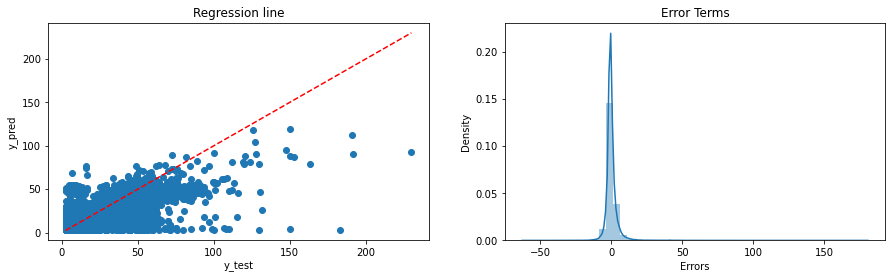

In [168]:
LR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = LR.predict(Train_X_std)
pred2 = LR.predict(Test_X_std)

print('\033[1mResults of Linear Regression Model\033[0m\n'.center(100))


Evaluate(0, pred1, pred2)

Ridge Regression Model

                             Results of Ridge Regression Model
                             

Training Set Metrics

R2-Score on Training set ---> 0.792329081446617
Mean Squared Error (MSE) on Training set       ---> 19.172792195180502
Root Mean Squared Error (RMSE) on Training set ---> 4.378674707623358
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.4435196751861732

Testing Set Metrics

R2-Score on Testing set ---> 0.7866987115660269
Mean Squared Error (MSE) on Test set       ---> 18.68468334043221
Root Mean Squared Error (RMSE) on Test set ---> 4.322578320913597
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.4439106211838704


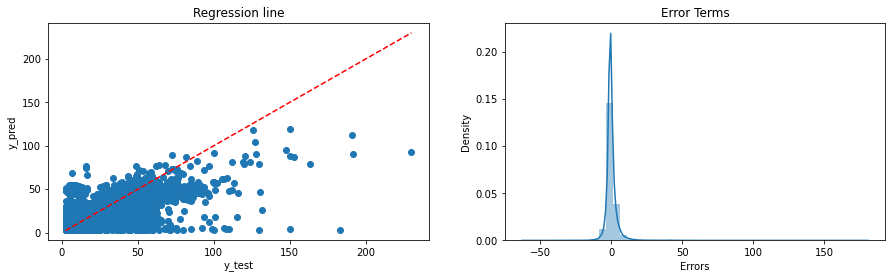

In [169]:
RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('\033[1mResults of Ridge Regression Model\033[0m\n'.center(100))


Evaluate(1, pred1, pred2)

Lasso Regression Model

                             Results of Lasso Regression Model
                             

Training Set Metrics

R2-Score on Training set ---> 0.7806051385056831
Mean Squared Error (MSE) on Training set       ---> 20.255181213731966
Root Mean Squared Error (RMSE) on Training set ---> 4.500575653594989
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.46463376347530355

Testing Set Metrics

R2-Score on Testing set ---> 0.7776530309848079
Mean Squared Error (MSE) on Test set       ---> 19.477063351353188
Root Mean Squared Error (RMSE) on Test set ---> 4.4132826049725375
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.4645685459968633


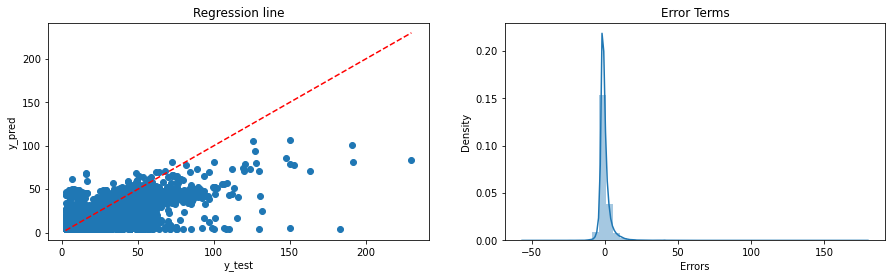

In [170]:
LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('\033[1mResults of Lasso Regression Model\033[0m\n'.center(100))

Evaluate(2, pred1, pred2)

Elastic-Net Regression

                          Results of ElasticNet Regression Model
                           

Training Set Metrics

R2-Score on Training set ---> 0.6817207253637194
Mean Squared Error (MSE) on Training set       ---> 29.384482117873237
Root Mean Squared Error (RMSE) on Training set ---> 5.420745531554975
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.5302912337404865

Testing Set Metrics

R2-Score on Testing set ---> 0.6828796472028361
Mean Squared Error (MSE) on Test set       ---> 27.77898537943107
Root Mean Squared Error (RMSE) on Test set ---> 5.270577328854124
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.529632785681696


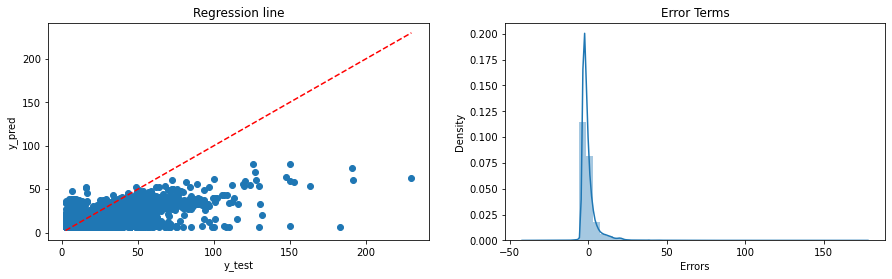

In [171]:
ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('\033[1mResults of ElasticNet Regression Model\033[0m\n'.center(100))

Evaluate(3, pred1, pred2)

Polynomial Regression

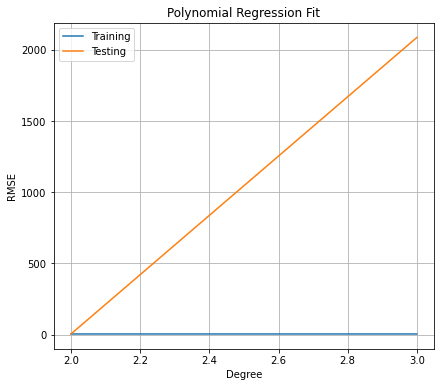

In [172]:
Train_RMSE=[] 
Test_RMSE=[]
n_degree=4

for i in range(2,n_degree):
    poly = PolynomialFeatures(degree=i)
    poly_train = poly.fit_transform(Train_X_std)
    poly_test = poly.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(poly_train, Train_Y)
    
    pred1 = LR.predict(poly_train)
    Train_RMSE.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(poly_test)
    Test_RMSE.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Train_RMSE, label='Training')
plt.plot(range(2,n_degree),Test_RMSE, label='Testing')

plt.title('Polynomial Regression Fit')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()

plt.show()


                          Results of Polynomial Regression Model
                           

Training Set Metrics

R2-Score on Training set ---> 0.7937963482832678
Mean Squared Error (MSE) on Training set       ---> 19.037329789804005
Root Mean Squared Error (RMSE) on Training set ---> 4.363178862916808
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.4460367195115058

Testing Set Metrics

R2-Score on Testing set ---> 0.7868603573607843
Mean Squared Error (MSE) on Test set       ---> 18.670523554945046
Root Mean Squared Error (RMSE) on Test set ---> 4.320940123971292
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.44631037371061355


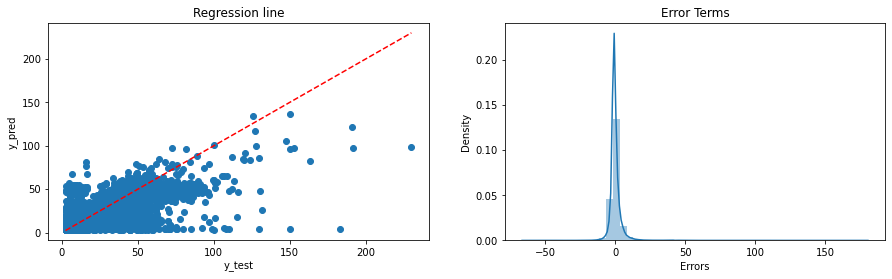

In [173]:
poly = PolynomialFeatures(degree=2)
poly_train = poly.fit_transform(Train_X_std)
poly_test = poly.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(poly_train, Train_Y)

pred1 = PR.predict(poly_train)
pred2 = PR.predict(poly_test)

print('\033[1mResults of Polynomial Regression Model\033[0m\n'.center(100))

Evaluate(4, pred1, pred2)

NN

In [174]:
def build_model(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu']) 
    
    model.add(Dense(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=8,   
                                   max_value=512,   
                                   step=16),
                    input_dim=(Train_X_std.shape[1]),
                    activation=activation_choice))
    
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
      model.add(Dense(units=hyperparams.Int('units_hidden',     
                                   min_value=8,   
                                   max_value=512,   
                                   step=16),
                      activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

In [175]:
from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model,
                      objective="val_mean_absolute_error",
                      max_trials=20,
                      project_name="Uber",
                      overwrite=True
                    )

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner1.search(Train_X_std, Train_Y, batch_size=128, epochs=20, validation_data=(Val_X_std, Val_Y), callbacks=[callback])

Trial 20 Complete [00h 00m 20s]
val_mean_absolute_error: 2.2215487957000732

Best val_mean_absolute_error So Far: 2.213724136352539
Total elapsed time: 00h 16m 17s
INFO:tensorflow:Oracle triggered exit


In [176]:
tuner1.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh', 'elu', 'selu'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 5, 'step': 1, 'sampling': None}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'rmsprop', 'adam'], 'ordered': False}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': None}


In [177]:
best_params = tuner1.get_best_hyperparameters()

best_params[0].values

{'activation': 'selu',
 'units_input': 264,
 'num_layers': 4,
 'optimizer': 'adam',
 'units_hidden': 376}

In [178]:
best_model = tuner1.get_best_models()[0]



best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 264)               3168      
                                                                 
 dense_1 (Dense)             (None, 376)               99640     
                                                                 
 dense_2 (Dense)             (None, 376)               141752    
                                                                 
 dense_3 (Dense)             (None, 376)               141752    
                                                                 
 dense_4 (Dense)             (None, 376)               141752    
                                                                 
 dense_5 (Dense)             (None, 1)                 377       
                                                                 
Total params: 528,441
Trainable params: 528,441
Non-trai

1210/1210 [==============================] - 4s 4ms/step
                                    Results of NN Model
                                    

Training Set Metrics

R2-Score on Training set ---> 0.7863904415517768
Mean Squared Error (MSE) on Training set       ---> 19.72106495970102
Root Mean Squared Error (RMSE) on Training set ---> 4.440840569047826
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.43785935341794113

Testing Set Metrics

R2-Score on Testing set ---> 0.7759689238138958
Mean Squared Error (MSE) on Test set       ---> 19.624587116590934
Root Mean Squared Error (RMSE) on Test set ---> 4.4299646857047215
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.4379022250142024


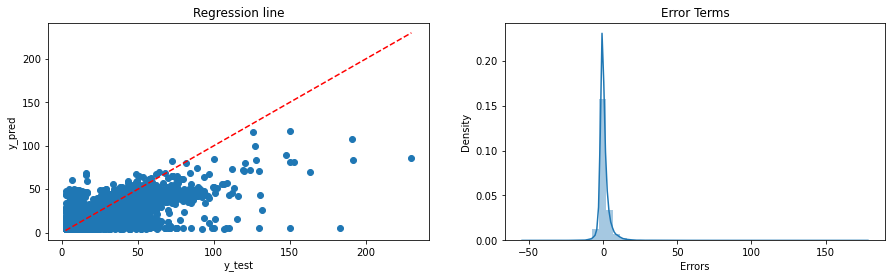

In [179]:
pred1 = best_model.predict(Train_X_std)
pred1 = pred1.reshape(pred1.shape[0])
pred2 = best_model.predict(Test_X_std)
pred2 = pred2.reshape(pred2.shape[0])

print('\033[1mResults of NN Model\033[0m\n'.center(100))


Evaluate(5, pred1, pred2)

RNN

In [180]:
train_X = Train_X_std.values
test_X = Test_X_std.values
val_X = Val_X_std.values
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [181]:
def build_model_RNN(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu']) 
    
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=8,   
                                   max_value=512,   
                                   step=16),
                    input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice))
    
#     for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
#       model.add(LSTM(units=hyperparams.Int('units_hidden',     
#                                    min_value=8,   
#                                    max_value=512,   
#                                    step=16),
#                       activation=activation_choice, return_sequences=True))
    
#     model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
#                                    min_value=8,   
#                                    max_value=512,   
#                                    step=16),
#                     activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

In [182]:
from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_RNN,
                      objective="val_mean_absolute_error",
                      max_trials=10,
                      project_name="Uber2",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner1.search(train_X, Train_Y, batch_size=128, epochs=20, validation_data=(val_X, Val_Y), callbacks=[callback])

Trial 10 Complete [00h 03m 39s]
val_mean_absolute_error: 2.2471179962158203

Best val_mean_absolute_error So Far: 2.2256100177764893
Total elapsed time: 00h 29m 09s
INFO:tensorflow:Oracle triggered exit


In [183]:
tuner1.search_space_summary()

Search space summary
Default search space size: 3
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh', 'elu', 'selu'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': None}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'rmsprop', 'adam'], 'ordered': False}


In [184]:
best_params = tuner1.get_best_hyperparameters()

best_params[0].values

{'activation': 'elu', 'units_input': 248, 'optimizer': 'adam'}

In [185]:
best_model = tuner1.get_best_models()[0]



best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 248)               257920    
                                                                 
 dense (Dense)               (None, 1)                 249       
                                                                 
Total params: 258,169
Trainable params: 258,169
Non-trainable params: 0
_________________________________________________________________


1210/1210 [==============================] - 3s 3ms/step
                                   Results of RNN Model
                                    

Training Set Metrics

R2-Score on Training set ---> 0.7914356706933132
Mean Squared Error (MSE) on Training set       ---> 19.255274513057984
Root Mean Squared Error (RMSE) on Training set ---> 4.388083239075802
Symmetric Mean Absolute Percentage Error (SMAPE) on Training set ---> 0.4405384615484918

Testing Set Metrics

R2-Score on Testing set ---> 0.7849823341190024
Mean Squared Error (MSE) on Test set       ---> 18.835033904771326
Root Mean Squared Error (RMSE) on Test set ---> 4.339934781165648
Symmetric Mean Absolute Percentage Error (SMAPE) on Test set ---> 0.44079795290608875


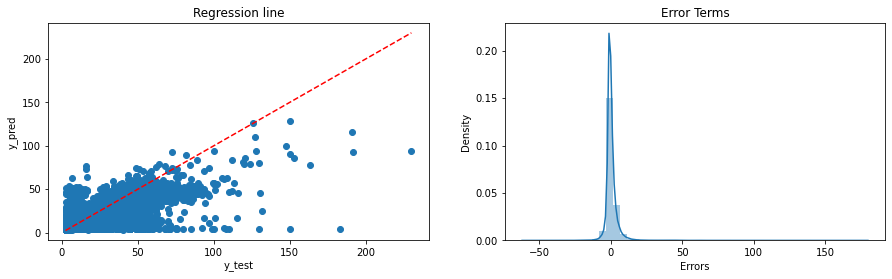

In [186]:
pred1 = best_model.predict(train_X)
pred1 = pred1.reshape(pred1.shape[0])
pred2 = best_model.predict(test_X)
pred2 = pred2.reshape(pred2.shape[0])

print('\033[1mResults of RNN Model\033[0m\n'.center(100))


Evaluate(6, pred1, pred2)

# Comparing without coordinates

In [187]:
Table_of_Comapring = For_Comparing.copy()
Table_of_Comapring.index = ['Linear Regression','Ridge Linear Regression','Lasso Linear Regression','Elastic-Net Regression','Polynomial Regression', 'NN', 'RNN']
Table_of_Comapring

,Train-R2,Test-R2,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE,Train-SMAPE,Test-SMAPE
Linear Regression,0.792329,0.786699,19.172792,18.684700,4.378675,4.322580,0.443519,0.443910
Ridge Linear Regression,0.792329,0.786699,19.172792,18.684683,4.378675,4.322578,0.443520,0.443911
Lasso Linear Regression,0.780605,0.777653,20.255181,19.477063,4.500576,4.413283,0.464634,0.464569
Elastic-Net Regression,0.681721,0.682880,29.384482,27.778985,5.420746,5.270577,0.530291,0.529633
Polynomial Regression,0.793796,0.786860,19.037330,18.670524,4.363179,4.320940,0.446037,0.446310
NN,0.786390,0.775969,19.721065,19.624587,4.440841,4.429965,0.437859,0.437902
RNN,0.791436,0.784982,19.255275,18.835034,4.388083,4.339935,0.440538,0.440798


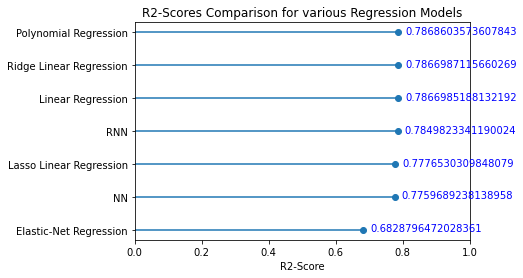

In [188]:
R2 = Table_of_Comapring['Test-R2'].sort_values(ascending=True)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v), color='blue')
plt.xlim([0,1])
plt.show()

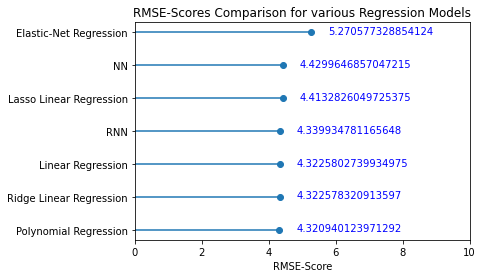

In [189]:
RMSE = Table_of_Comapring['Test-RMSE'].sort_values(ascending=True)
plt.hlines(y=RMSE.index, xmin=0, xmax=RMSE.values)
plt.plot(RMSE.values, RMSE.index,'o')
plt.title('RMSE-Scores Comparison for various Regression Models')
plt.xlabel('RMSE-Score')
for i, v in enumerate(RMSE):
    plt.text(v+0.5, i-0.05, str(v), color='blue')
plt.xlim([0,10])
plt.show()

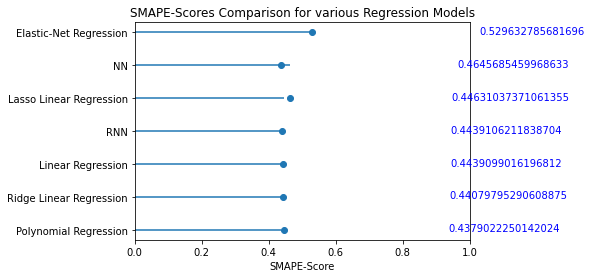

In [190]:
SMAPE = Table_of_Comapring['Test-SMAPE'].sort_values(ascending=True)
plt.hlines(y=RMSE.index, xmin=0, xmax=SMAPE.values)
plt.plot(SMAPE.values, SMAPE.index,'o')
plt.title('SMAPE-Scores Comparison for various Regression Models')
plt.xlabel('SMAPE-Score')
for i, v in enumerate(SMAPE):
    plt.text(v+0.5, i-0.05, str(v), color='blue')
plt.xlim([0,1])
plt.show()

# Conclusions

Изначальный набор данных имеет 200000 строк и следующие признаки: количество пассажиров, дата поездки, координаты долготы старта поездки, координаты широты старта поездки, координаты долготы конца поездки, координаты широты конца поездки, стоимость поездки. Стоимость поездки - целевая переменная.

После преобразоования датасета были добавлены следующие признаки: расстояние поездки, день недели, время суток, время года.

Признаки имеют довольно значительные отклонения и высокую мультиколлинеарность

После исследования признаков было выяснено, что модель с признаками: количество пассажиров, расстояние поездки, день недели и время года объясняет около 80 процентов изменчивости зависимой переменной

Было протестированно несколько алгоритмов регрессии, алгоритм нейронной сети и реккурентной нейронной сети. Лучшим выбором оказалась полиномиальная регрессия